In [1]:
# instead, now train each cycle with independent networks (e.g. don't mix the inputs of the 6 month cycles with the 
# 3 month cycles)

# when the inputs are mixed (analogous to the independent networks being connected), we can (? in theory - to be tested) achieve
# arbitrarily high training accuracy with a large enough network (i.e. overfit the data). by first separating the inputs, 
# and then joining the intermediate outputs with a final network, we hope to find "real" signal rather than noise

# but: is there a fundamental reason why 3 month or 6 month cycles might contain signal? ("alpha")
# time periods/cycles are hyperparameters of this model

In [1]:
import pandas as pd
import numpy as np
import os.path 
import pandas_datareader.data as web
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import gmean

%matplotlib inline
plt.style.use('ggplot')

In [7]:
# predict bearish/bullish signal for the next month based on price data from previous 6 months
# 1 - net positive return over the subsequent month. 0 - net negative return over the subsequent month. 

timelinedata = pd.read_csv('timeline-data/IBM-timeline-data.csv')

features = pd.read_csv('timeline-data/IBM-features.csv')
targets = pd.read_csv('timeline-data/IBM-targets.csv')
targets = targets.apply(lambda x: x > 0).astype(int)

In [149]:
# historical price data suggests an approximate random walk. (about as many bullish months as bearish)

targets.sum()/len(targets)

0    0.537953
dtype: float64

In [115]:
# net return over the entire period. equivalently, we could take the geometric mean..that'd just be taking the n-th root

sixmonthreturns = []

for i in range(len(features)):
    sixmonthreturns.append(np.prod(features.iloc[i]+1)-1)
    
sixmonthreturns = np.array(sixmonthreturns)

In [116]:
# net return over each half (3 month period)

threemonthreturns = []

for i in range(len(features)):
    threemonthreturns.append([np.prod(features.iloc[i][:63]+1)-1,np.prod(features.iloc[i][63:]+1)-1])
    
threemonthreturns = np.array(threemonthreturns)

In [148]:
# net return over each third (2 month period)

twomonthreturns = []

for i in range(len(features)):
    twomonthreturns.append([np.prod(features.iloc[i][0:42]+1)-1,
                            np.prod(features.iloc[i][42:84]+1)-1,
                            np.prod(features.iloc[i][84:]+1)-1])
    
twomonthreturns = np.array(twomonthreturns)

In [179]:
# col 0 - 6 month return. col 1 - first 3 month return. col 2 - seocnd 3 month return. col 3 - first 2 month return
# col 4 - second 2 month return. col 5 - third 2 month return. 

# is it a good idea to mix all the periods like this..? to be seen if there is an underlying function of the cycles
# that will be approximated by the feed forward NN

# will not bother with normalizing the inputs for now.. since all the inputs are on the same scale already

# RNN is probably a better approach

final_features = pd.DataFrame(sixmonthreturns)
final_features[1] = threemonthreturns[:,0]
final_features[2] = threemonthreturns[:,1]
final_features[3] = twomonthreturns[:,0]
final_features[4] = twomonthreturns[:,1]
final_features[5] = twomonthreturns[:,2]

In [275]:
# .drop() to remove the 2-month periods. they may be adding more noise than value..too many inputs

features_train = final_features[:-1000]#.drop([3,4,5],axis=1)
targets_train = targets[:-1000]

features_test = final_features[-1000:]#.drop([3,4,5],axis=1)
targets_test = targets[-1000:]

In [324]:
import tensorflow as tf

model = tf.keras.Sequential()

layer_hidden_units = [6,6,6,5,4,3,2,1]

for i,hu in enumerate(layer_hidden_units):
    if i == 0: # need to specify input dimensions for the first layer
        model.add(tf.keras.layers.Dense(hu,activation='relu',input_dim=6,
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal))
        continue
    if i == len(layer_hidden_units)-1: # different activation for the output layer
        model.add(tf.keras.layers.Dense(hu,activation='sigmoid'))
        continue
        
    model.add(tf.keras.layers.Dense(hu,activation='relu',kernel_initializer=tf.keras.initializers.TruncatedNormal))
    
    
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [325]:
import time

train_acc = []
test_acc = []
iters = 300

tic = time.time()
for i in range(iters):
    model.fit(features_train.values,targets_train.values,epochs=1,batch_size=len(features_train),verbose=0)
    train_acc.append(model.evaluate(features_train.values,targets_train.values,verbose=0)[1])
    test_acc.append(model.evaluate(features_test.values,targets_test.values,verbose=0)[1])
toc = time.time()
print(toc-tic)

186.8700292110443


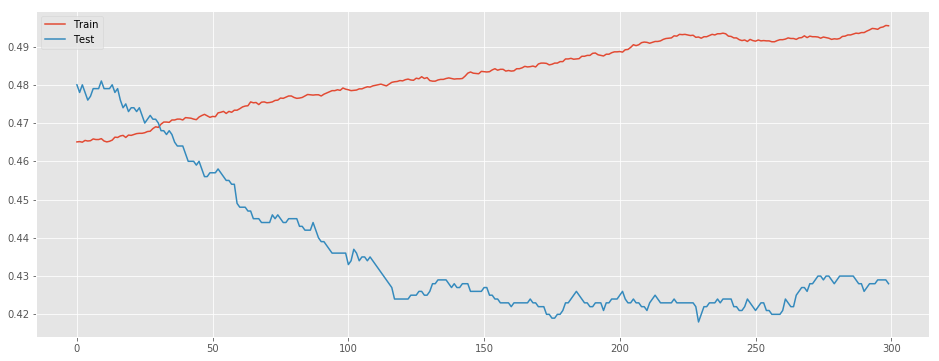

In [328]:
# performance level is not better than guessing (50-50 ish)
# test accuracy initially higher due to counts of each class (the untrained NN happens to predict more test cases correctly)

fig, ax = plt.subplots(1,1,figsize=(16,6))

ax.plot(list(range(iters)),train_acc)
ax.plot(list(range(iters)),test_acc)
ax.legend(['Train','Test'])
#ax.set_ylim([0,0.9])